### A coding scheme for Simon game sequences

#### **Author:** Sol Markman (smarkman@mit.edu)

Assumption: This scheme is hierarchical, so that different chunk types take priority over others. For example, repeats of a single color are chunked first, then repeats of multiple colors, then nested repeats, and then alternations are chunked with the remaining items, etc.
- RRRGRGRG is compressed to [R]3 [GR]2 G, size=6
- RRRGRG is compressed to [R]3 [GRG], size=4

#### Types of chunks/compression and their sizes:

#### 1) Repeats
Size = (size of subsequence) + 1. This assumes that size does not increase with the number of repeats, and 
repeats are only beneficial for size>2.

Single color repeats
- RRRR is compressed to [R]4, size=2

Multicolor repeats
- RGRGRG is compressed to [RG]3, size=3
    
Nested repeats
- RRRGGGRRRGGG is compressed to [ [R]3 [G]3 ]2, size=5

#### 2) Alternations
- ABA is compressed to AB*, size=2

#### 3) Cycles 
size = 3: start, length, direction (+ denotes CW, - denotes CCW)
(Y top left, B top right, G bottom right, R bottom left) 
- YBGR is compressed to Y4+ 
- YBGRY is compressed to Y5+
- GBYR = G4-

#### 4) Exposure compression (within a sequence)
Not yet implemented


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import matplotlib.gridspec as gridspec

from common_methods import *

In [2]:
# testing simple repeats scheme
test_sequences = ['BBBRRRYYYGGG', 'RRRZGZRRR', 'BBBBGRY', 'RRRYGYGYG', 'GBGBB', 
                    'BBBBBBBrrrBBBBBB', 'GGGGGGGG', 'ABCD', 'BGGGR', 'abbabbabba']
answers = [8, 7, 5, 8, 5, 6, 2, 4, 4, 10]
print('Simple repeat scheme test:')
test_coding_scheme(simple_repeat_scheme, test_sequences, answers)

Simple repeat scheme test:
BBBRRRYYYGGG 8
[B]3[R]3[Y]3[G]3 8
RRRZGZRRR 7
[R]3ZGZ[R]3 7
BBBBGRY 5
[B]4GRY 5
RRRYGYGYG 8
[R]3YGYGYG 8
GBGBB 5
GBG[B]2 5
BBBBBBBrrrBBBBBB 6
[B]7[r]3[B]6 6
GGGGGGGG 2
[G]8 2
ABCD 4
ABCD 4
BGGGR 4
B[G]3R 4
abbabbabba 10
a[b]2a[b]2a[b]2a 10


In [3]:
# testing complex repeats scheme
test_sequences = ['BBBRRRYYYGGG', 'RRRZGZRRR', 'BBBBGRY', 'RRRYGYGYG', 'GBGBB', 
                'BBBBBBBrrrBBBBBB', 'GRGRGRZDZDZDZTTTTTTTGGG', 'ababcdcdababcdcd',
                'abbabbabba', 'abcabcabc', 'abbccccabbccccabbcccc', 'bbbbaaaabbbbaaaa',
                'bbbaaabbbaaa', 'bbaabbaa', 'baba', 'bbaabbaab']
answers = [8, 7, 5, 5, 5, 6, 11, 7, 5, 4, 6, 5, 5, 5, 3, 6]
print('\nComplex repeat scheme test:')
test_coding_scheme(complex_repeat_scheme, test_sequences, answers)


Complex repeat scheme test:
BBBRRRYYYGGG 8
[B]3[R]3[Y]3[G]3 8
RRRZGZRRR 7
[R]3ZGZ[R]3 7
BBBBGRY 5
[B]4GRY 5
RRRYGYGYG 5
[R]3[YG]3 5
GBGBB 5
GBG[B]2 5
BBBBBBBrrrBBBBBB 6
[B]7[r]3[B]6 6
GRGRGRZDZDZDZTTTTTTTGGG 11
[GR]3[ZD]3Z[T]7[G]3 11
ababcdcdababcdcd 7
[[ab]2[cd]2]2 7
abbabbabba 5
[a[b]2]3a 5
abcabcabc 4
[abc]3 4
abbccccabbccccabbcccc 6
[a[b]2[c]4]3 6
bbbbaaaabbbbaaaa 5
[[b]4[a]4]2 5
bbbaaabbbaaa 5
[[b]3[a]3]2 5
bbaabbaa 5
[[b]2[a]2]2 5
baba 3
[ba]2 3
bbaabbaab 6
[[b]2[a]2]2b 6


In [4]:
# testing repeats-alternations scheme
test_sequences = ['BBBRYRGYG', 'BRBRBGTG', 'ABACBCDEDFGF']
answers = [6, 6, 8]

test_coding_scheme(complexrepeat_alternation_scheme, test_sequences, answers)

BBBRYRGYG 6
[B]3[RY*][GY*] 6
BRBRBGTG 6
[BR]2B[GT*] 6
ABACBCDEDFGF 8
[AB*][CB*][DE*][FG*] 8


In [5]:
# testing cycles-repeats-alternations scheme
weight_dirs = 0.5
test_sequences = ['YBGRYBGRt', 'GBYRBGRYB', 'YBGRY', 'YYYYYBGRY', 'BBBBBBBGBYRYR', 'YBGRRGBYYBGR']
answers = [3 + weight_dirs, 4 + 2*weight_dirs, 2 + weight_dirs, 4 + weight_dirs, 6 + weight_dirs, 6 + 3*weight_dirs] # repeats chunked first
test_coding_scheme(lambda x: cycle_rep_alt_scheme(x, weight_dirs), test_sequences, answers)

YBGRYBGRt 3.5
[Y8+]t 3.5
GBYRBGRYB 5.0
[G4-][B5+] 5.0
YBGRY 2.5
[Y5+] 2.5
YYYYYBGRY 4.5
[Y]4[Y5+] 4.5
BBBBBBBGBYRYR 6.5
[B]7[G4-]YR 6.5
YBGRRGBYYBGR 7.5
[Y4+][R4-][Y4+] 7.5


In [9]:
# testing cycles_Zs-repeats-alternations scheme
weight_dirs = 0.5

def cycle_Z_rep_alt_scheme(seq, weight_dirs=1):
    # ADD Zs
    result = []
    i = 0
    CW = ''.join(np.tile('YBGR', len(seq)//4 + 1))
    CCW = ''.join(np.tile('RGBY', len(seq)//4 + 1))
    while i < len(seq):
        if seq[i] == '[':
            j = i
            while seq[j] != ']':
                j += 1
            result.append(seq[i:j+1])
            i = j + 1
        else:
            if i + 3 < len(seq) and seq[i:i+3] in CW:
                j = i + 3
                while j < len(seq) and seq[i:j+1] in CW:
                    j += 1
                result.append(f'[{seq[i]}{j-i}+]')
                i = j
            elif i + 3 < len(seq) and seq[i:i+3] in CCW:
                j = i + 3
                while j < len(seq) and seq[i:j+1] in CCW:
                    j += 1
                result.append(f'[{seq[i]}{j-i}-]')
                i = j
            else:
                result.append(seq[i])
                i += 1
    
    seq_c = ''.join(result)
    code = complexrepeat_alternation_scheme(seq_c)[1]
    dir_count = code.count('+') + code.count('-')
    code_len = len(code.replace('[', '').replace(']', '').replace('*', '')) \
                + (weight_dirs - 1)*dir_count
    return code_len, code

In [20]:
# Within-subjects analysis

np.random.seed(1234)
data_path = './Sol_logs/Random' #'./Jack_logs' #'./Trautman_logs' #  './Quilee_logs' # './Hokyung_logs' #
chunk_dict = get_chunkabilities_from_logs(data_path)

scores = chunk_dict['scores']
print('# games: ', len(scores))

chunk_keys = default_scheme_keys
N_schemes = len(chunk_keys)

ylabel = 'Chunkability'

print('Scheme: slope, intercept, r-value, p-value, std_err')
lin_regs = []
for key in chunk_keys:
    chunk = chunk_dict[key]
    m, b, r, p, std_err = stats.linregress(scores, chunk)
    lin_regs.append((m, b, r, p, std_err))
    print(f'{key}:', m, b, r, p, std_err)

fig, ax = plt.subplots(1, N_schemes, figsize=(2+4*N_schemes, 4), sharex=False, sharey=True)

ax[0].scatter(scores, chunk1, alpha=0.6)
ax[1].scatter(scores, chunk2, alpha=0.6)
ax[2].scatter(scores, chunk3, alpha=0.6)
ax[3].scatter(scores, chunk4, alpha=0.6)
ax[4].scatter(scores, chunk5, alpha=0.6)
ax[0].set(ylabel=ylabel, xlabel='Score', title='Simple repeat chunking')
ax[1].set(ylabel=ylabel, title='Cycles')#'Lempel-Ziv complexity')
ax[2].set(ylabel=ylabel, title='Complex repeat chunking')
ax[3].set(ylabel=ylabel, title='Alternations') #'Repeat alternation chunking')
ax[4].set(ylabel=ylabel, title='Cycle-repeat-alternation chunking')

ax[0].plot(np.array(scores), m1*np.array(scores) + b1, color='k', zorder=0, 
           label=f'p-value: {p1:.2e}, R: {r1:.2f}')
ax[1].plot(np.array(scores), m2*np.array(scores) + b2, color='k', zorder=0, 
           label=f'p-value: {p2:.2e}, R: {r2:.2f}')
ax[2].plot(np.array(scores), m3*np.array(scores) + b3, color='k', zorder=0, 
           label=f'p-value: {p3:.2e}, R: {r3:.2f}')
ax[3].plot(np.array(scores), m4*np.array(scores) + b4, color='k', zorder=0, 
           label=f'p-value: {p4:.2e}, R: {r4:.2f}')
ax[4].plot(np.array(scores), m5*np.array(scores) + b5, color='k', zorder=0,
            label=f'p-value: {p5:.2e}, R: {r5:.2f}')

ax[0].legend(loc='lower right')
ax[1].legend(loc='lower right')
ax[2].legend(loc='lower right')
ax[3].legend(loc='lower right')
ax[4].legend(loc='lower right')

fig.suptitle(f'For logs in {data_path}')

KeyError: 'simple_repeats'

In [13]:
# Combining data across subjects
# This approach tries to account for the different number of games
# and the different distributions of scores for each subject by computing a 
# within-subject score percentile, only including subjects with scores in each 
# pre-defined score percentile bin (e.g. [0, 25, 50, 75, 100]),
# and then computing the average chunkability for each bin.
# So each subject contributes one data point to each bin.

np.random.seed(1234)

# First, find which subjects meet the criteria for inclusion

data_paths_ = ['./Ajani_logs', './Annesya_logs', './Gershman_logs', './Hokyung_logs',
               './Jack_logs', './Mahdi_logs', './Mel_logs', './Nathan_logs', 
               './Nick_logs', './Quilee_logs', './Sagarika_logs', './Sol_logs/Random', 
               './Trautman_logs', './Vin_logs']
N_subjects = len(data_paths_)
N_games = np.zeros(N_subjects, dtype=int)
median_scores = np.zeros(N_subjects, dtype=int)
score_ranges = np.zeros((N_subjects, 2), dtype=int)

pbins = [-1, 25, 50, 75, 101]
N_quants = len(pbins) - 1
min_per_bin = 2
min_score = 5 # CHANGE THRESHOLD HERE

subs_to_include = []

for i, data_path in enumerate(data_paths_):

    score_dict = get_chunkabilities_from_logs(data_path, get_chunkability=None)
    scores = np.array(score_dict['scores'])
    scores = scores[scores >= min_score]
    N_games[i] = len(scores)
    median_scores[i] = np.median(scores)
    score_ranges[i] = [np.min(scores), np.max(scores)]

    if N_games[i] < N_quants*min_per_bin:
        continue

    score_percentiles = np.array([stats.percentileofscore(scores, i, kind='mean') for i in scores])
    score_quantiles = np.digitize(score_percentiles, pbins)

    n_per_bin = [np.where(score_quantiles == j+1)[0].shape[0] for j in range(N_quants)]
    if np.min(n_per_bin) < min_per_bin:
        continue
    
    subs_to_include.append(i)
    print(f'{data_path}: {N_games[i]} games, median score: {median_scores[i]}, range: {score_ranges[i]}')


# Compute chunkability averages for each subject that meets the criteria

chunk_keys = default_scheme_keys
N_schemes = len(chunk_keys)
N_subs = len(subs_to_include)
all_chunk_avgs = np.zeros((N_subs, N_quants, N_schemes))

for sub in range(N_subs):

    data_path = data_paths_[subs_to_include[sub]]
    chunk_dict = get_chunkabilities_from_logs(data_path)
    scores = np.array(chunk_dict['scores'])
    game_idx = np.where(scores >= min_score)[0]
    scores = scores[game_idx]
    score_percentiles = np.array([stats.percentileofscore(scores, sc, kind='mean') for sc in scores])
    score_quantiles = np.digitize(score_percentiles, pbins)

    for q in range(N_quants):
        idx_q = np.where(score_quantiles == q+1)[0]
        
        for s in range(N_schemes):
            all_chunk_avgs[sub, q, s] = np.mean(np.array(chunk_dict[chunk_keys[s]])[game_idx][idx_q])

./Hokyung_logs: 17 games, median score: 19, range: [ 8 35]
./Jack_logs: 18 games, median score: 14, range: [ 5 31]
./Quilee_logs: 14 games, median score: 7, range: [ 5 17]
./Sol_logs/Random: 50 games, median score: 9, range: [ 5 16]
./Trautman_logs: 24 games, median score: 8, range: [ 5 11]


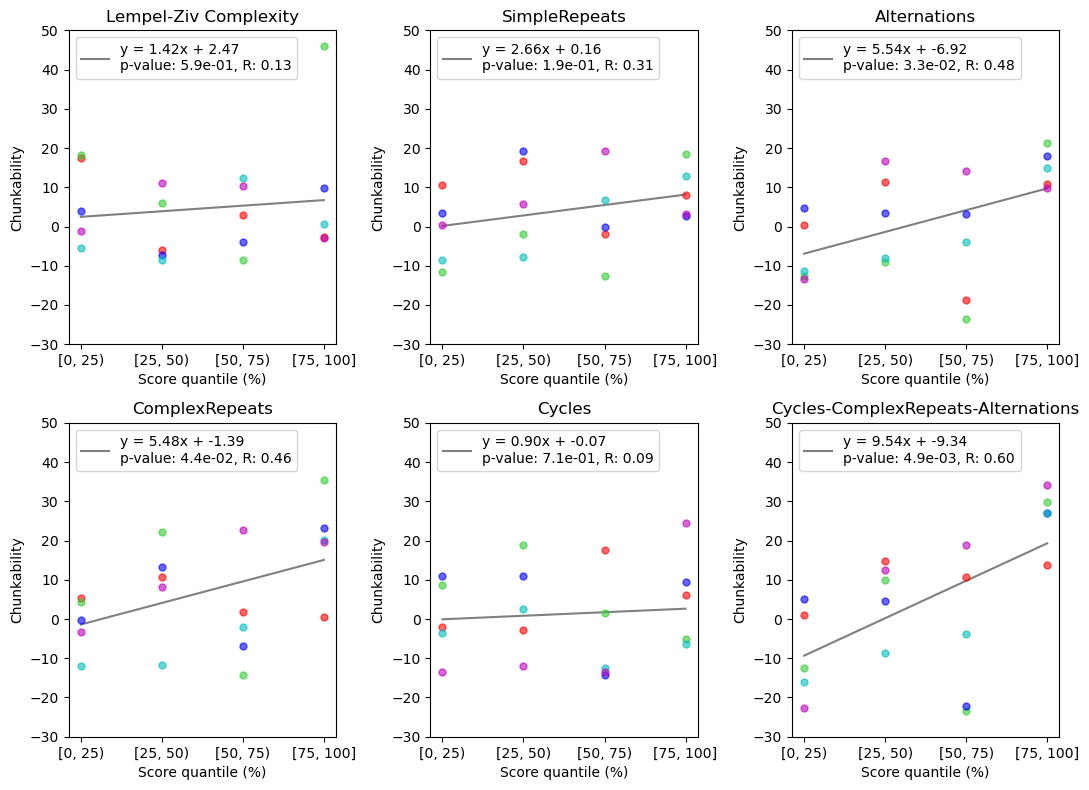

In [18]:
# Plot
colors = ['r', 'limegreen', 'b', 'c', 'm']
alpha = 0.6
sz = 25

fig = plt.figure(figsize=(11, 8))
gs = gridspec.GridSpec(2, 3)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[1, 0])
ax5 = fig.add_subplot(gs[1, 1])
ax6 = fig.add_subplot(gs[1, 2])

scheme_names = default_scheme_keys

x = np.arange(N_quants)
for s, ax in enumerate([ax1, ax2, ax3, ax4, ax5, ax6]):
    for sub in range(N_subs):

        ax.scatter(x, all_chunk_avgs[sub, :, s], alpha=alpha, color=colors[sub], s=sz)

# Linear regression
x_reg = np.tile(x, (all_chunk_avgs.shape[0]))
lin_regs = dict(ms=[], bs=[], rs=[], ps=[], std_errs=[])

for s, ax in enumerate([ax1, ax2, ax3, ax4, ax5, ax6]):
    m, b, r, p, std_err = stats.linregress(x_reg, all_chunk_avgs[:, :, s].flatten())
    lin_regs['ms'].append(m)
    lin_regs['bs'].append(b)
    lin_regs['rs'].append(r)
    lin_regs['ps'].append(p)
    lin_regs['std_errs'].append(std_err)

    ax.plot(x, m*x + b, color='grey', zorder=0,
            label=f'y = {m:.2f}x + {b:.2f}\np-value: {p:.1e}, R: {r:.2f}')

    ax.set(xlabel='Score quantile (%)', ylabel='Chunkability', title=scheme_names[s])
    ax.set_yticks(np.arange(-30, 51, 10))
    ax.set_xticks(x)
    ax.set_xticklabels(['[0, 25)', '[25, 50)', '[50, 75)', '[75, 100]'])
    ax.legend(loc='upper left')

plt.tight_layout()
plt.savefig(f'./Simon_allsubs_analysis_thresh{min_score}.png', dpi=500)


Text(0.5, 0.98, 'Simulated random data')

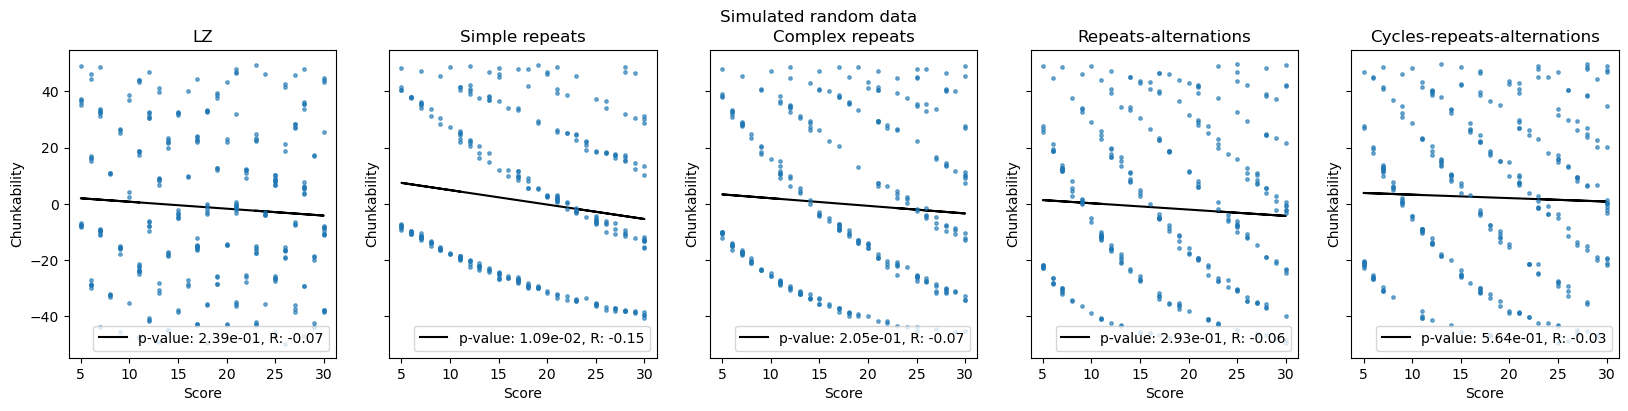

In [12]:
# Check that randomly simulated data yields no chunkability correlation

# Calculate chunkabilities for random sequences

np.random.seed(128)
N_samples = 300
random_seqs = sample_random_sequences(30, N_samples, min=5)
lengths = np.array([len(seq) for seq in random_seqs])

schemes = default_schemes
scheme_names = default_scheme_keys
N_schemes = len(schemes)

chunkabilities = np.zeros((N_schemes, N_samples))
measure = get_chunkability_percentile
for i in range(N_schemes):
    chunkabilities[i] = get_measure_multiple_seqs(schemes[i], random_seqs, measure)

# Linear regression
lin_regs = dict(ms=[], bs=[], rs=[], ps=[], std_errs=[])
for i in range(N_schemes):
    m, b, r, p, std_err = stats.linregress(lengths, chunkabilities[i])
    lin_regs['ms'].append(m)
    lin_regs['bs'].append(b)
    lin_regs['rs'].append(r)
    lin_regs['ps'].append(p)
    lin_regs['std_errs'].append(std_err)

s = 6
alpha = 0.6
fig, ax = plt.subplots(1, N_schemes, figsize=(N_schemes*4, 4), sharex=False, sharey=True)
for i in range(N_schemes):
    ax[i].scatter(lengths, chunkabilities[i], alpha=alpha, s=s)
    ax[i].plot(lengths, lin_regs['ms'][i]*lengths + lin_regs['bs'][i], color='k', zorder=0,
                label=f'p-value: {lin_regs["ps"][i]:.2e}, R: {lin_regs["rs"][i]:.2f}')
    ax[i].set(ylabel='Chunkability', xlabel='Score', title=scheme_names[i])
    ax[i].legend(loc='lower right')
fig.suptitle(f'Simulated random data')

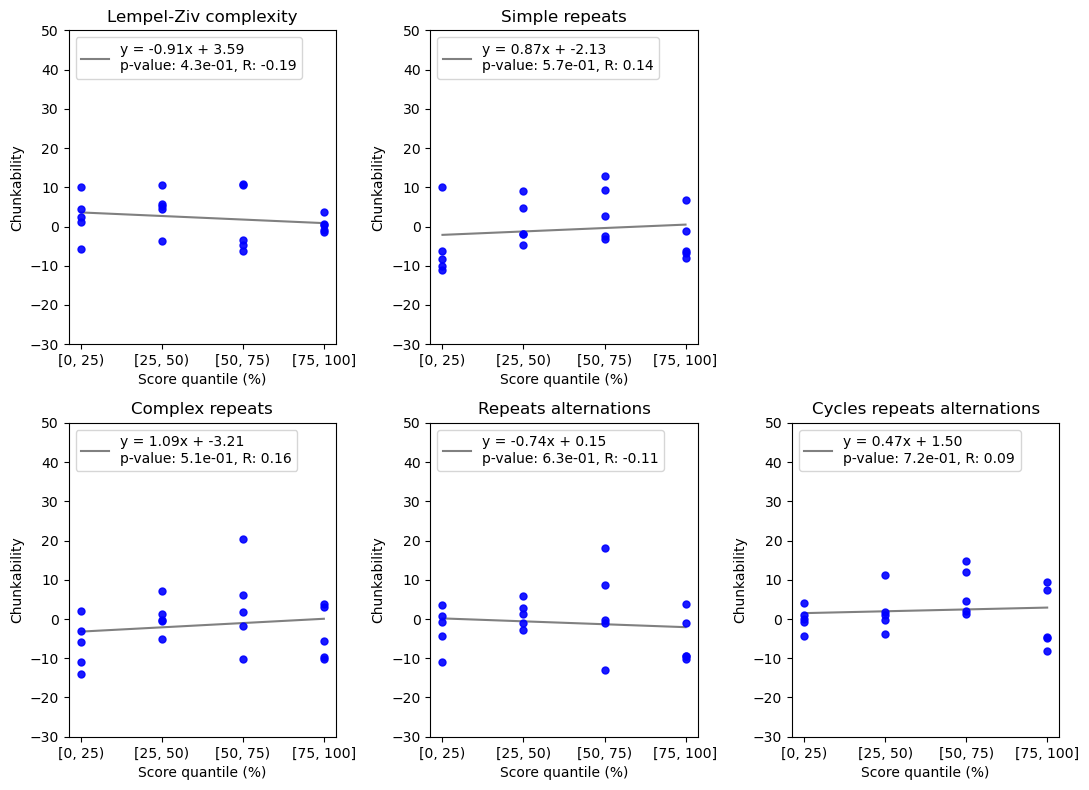

In [24]:
# Quartile analysis for random sequences
np.random.seed(128)

# Calculate score quartiles
pbins = [-1, 25, 50, 75, 101]
N_quants = len(pbins) - 1
N_iters = 5

chunk_avgs = np.zeros((N_iters, N_schemes, N_quants))
chunk_medians = np.zeros((N_iters, N_schemes, N_quants))

for n in range(N_iters):
    idx_n = np.random.randint(0, N_samples, N_samples//N_iters)
    length_percentiles = np.array([stats.percentileofscore(lengths[idx_n], i, kind='mean') for i in lengths[idx_n]])
    length_quantiles = np.digitize(length_percentiles, pbins)

    for q in range(N_quants):

        idx_q = np.where(length_quantiles == q+1)[0]
        if idx_q.shape[0] < min_per_bin:
            print('Not enough data: ', q)
            continue

        for s in range(N_schemes):
            chunk_avgs[n, s, q] = np.mean(np.array(chunkabilities[s])[idx_q])

# Linear regression
lin_regs = dict(ms=[], bs=[], rs=[], ps=[], std_errs=[])
x_reg = np.tile(x, N_iters)
for s in range(N_schemes):
    m, b, r, p, std_err = stats.linregress(x_reg, chunk_avgs[:, s, :].flatten())
    lin_regs['ms'].append(m)
    lin_regs['bs'].append(b)
    lin_regs['rs'].append(r)
    lin_regs['ps'].append(p)
    lin_regs['std_errs'].append(std_err)

# Plot
alpha = 0.9
sz = 25

fig = plt.figure(figsize=(11, 8))
gs = gridspec.GridSpec(2, 3)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[1, 2])

for s, ax in enumerate([ax1, ax2, ax3, ax4, ax5]):
    for n in range(N_iters):
        ax.scatter(x, chunk_avgs[n, s], alpha=alpha, color='b', s=sz)
        
    ax.plot(x, lin_regs['ms'][s]*x + lin_regs['bs'][s], color='grey', zorder=0,
            label=f'y = {lin_regs["ms"][s]:.2f}x + {lin_regs["bs"][s]:.2f}\np-value: {lin_regs["ps"][s]:.1e}, R: {lin_regs["rs"][s]:.2f}')
    
    ax.set(xlabel='Score quantile (%)', ylabel='Chunkability',
            title=['Lempel-Ziv complexity', 'Simple repeats', 'Complex repeats', 
                    'Repeats alternations', 'Cycles repeats alternations'][s])
    ax.set_yticks(np.arange(-30, 51, 10))
    ax.set_xticks(x)
    ax.set_xticklabels(['[0, 25)', '[25, 50)', '[50, 75)', '[75, 100]'])
    ax.legend(loc='upper left')

plt.tight_layout()

[Text(0.5, 0, 'Sequence length'),
 Text(0, 0.5, 'Code length'),
 Text(0.5, 1.0, 'Lempel-Ziv complexity')]

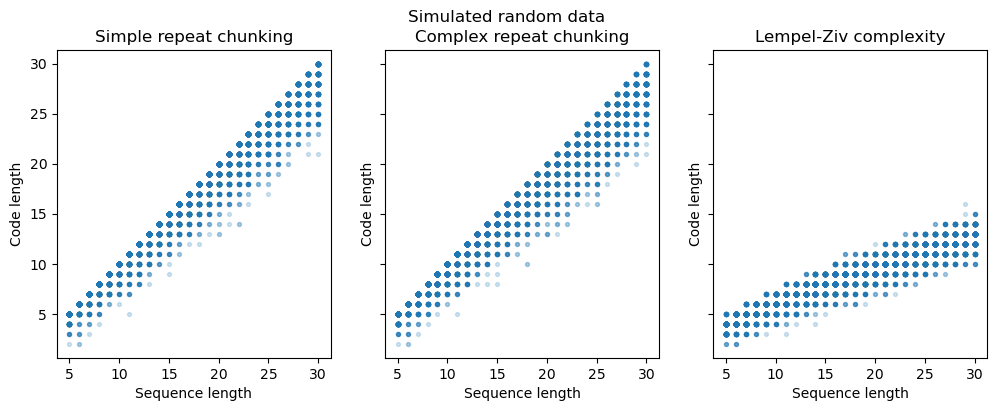

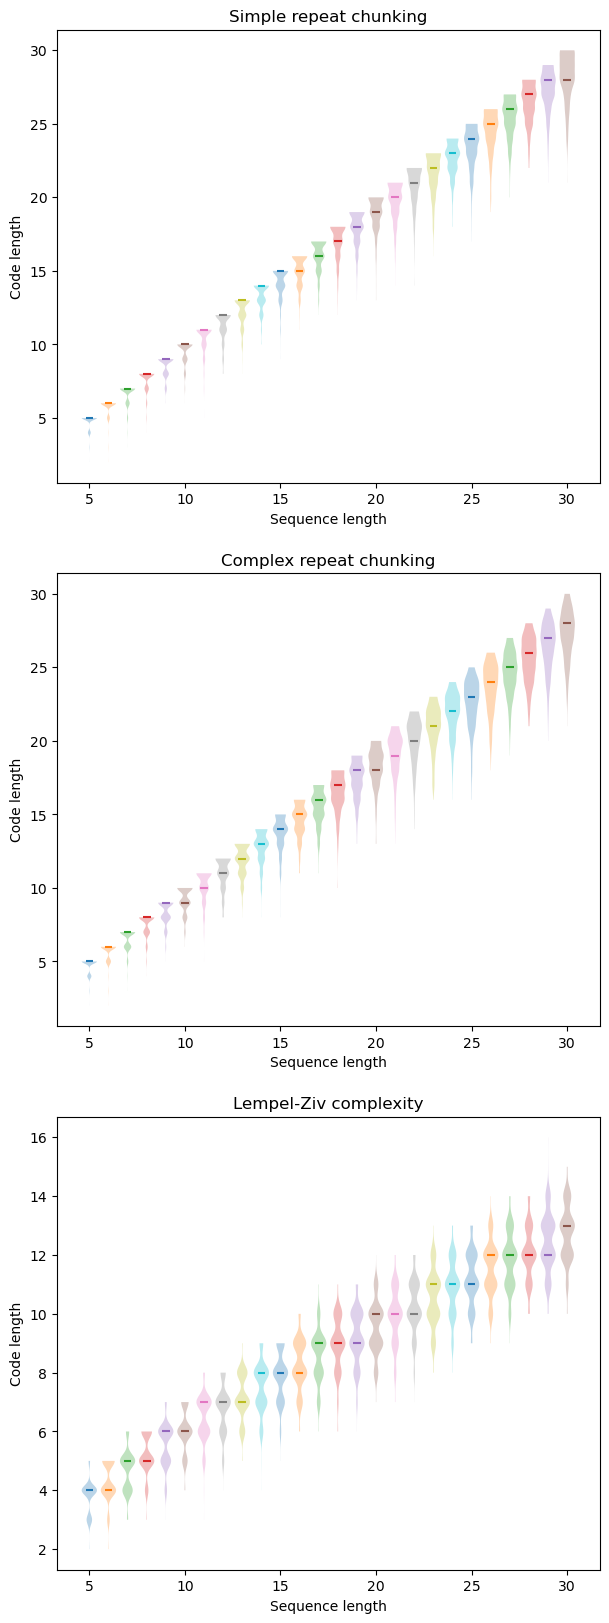

In [95]:
np.random.seed(128)
random_seqs = sample_random_sequences(30, 10000, min=5)
lengths = np.array([len(seq) for seq in random_seqs])

codelen1 = get_measure_multiple_seqs(simple_repeat_scheme, random_seqs, get_code_lengths)
codelen2 = get_measure_multiple_seqs(LZ_scheme, random_seqs, get_code_lengths)
codelen3 = get_measure_multiple_seqs(complex_repeat_scheme, random_seqs, get_code_lengths)

unique_lens = np.unique(lengths)

fig, ax = plt.subplots(3, 1, figsize=(7, 20))
quantiles = []
for l in unique_lens:
    idx = np.where(lengths == l)
    ax[0].violinplot(codelen1[idx], positions=[l], showextrema=False, 
                     showmedians=True, quantiles=quantiles, widths=0.8)
    ax[1].violinplot(codelen3[idx], positions=[l], showextrema=False, 
                     showmedians=True, quantiles=quantiles, widths=0.8)
    ax[2].violinplot(codelen2[idx], positions=[l], showextrema=False, 
                     showmedians=True, quantiles=quantiles, widths=0.8)

ax[0].set(xlabel='Sequence length', ylabel='Code length', title='Simple repeat chunking')
ax[1].set(xlabel='Sequence length', ylabel='Code length', title='Complex repeat chunking')
ax[2].set(xlabel='Sequence length', ylabel='Code length', title='Lempel-Ziv complexity')

fig.suptitle(f'Simulated random data')

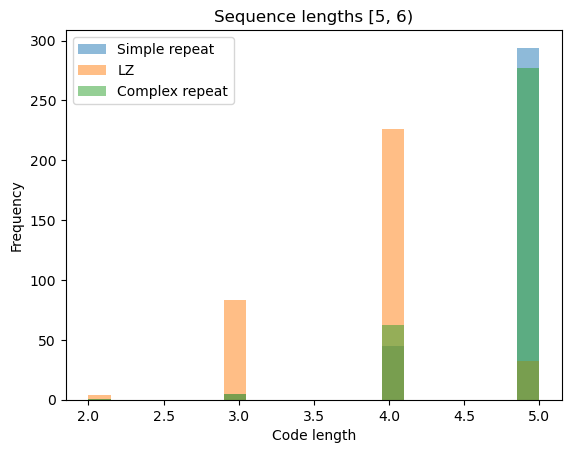

In [25]:
min_len = 5
max_len = 6
inds = np.where((np.array(lengths) >= min_len) & (np.array(lengths) < max_len))[0]

plt.hist(codelen1[inds], bins=20, alpha=0.5, label='Simple repeat')
plt.hist(codelen2[inds], bins=20, alpha=0.5, label='LZ')
plt.hist(codelen3[inds], bins=20, alpha=0.5, label='Complex repeat')
plt.xlabel('Code length')
plt.ylabel('Frequency')
plt.title(f'Sequence lengths [{min_len}, {max_len})')
plt.legend()

Text(0, 0.5, 'Chunkability')

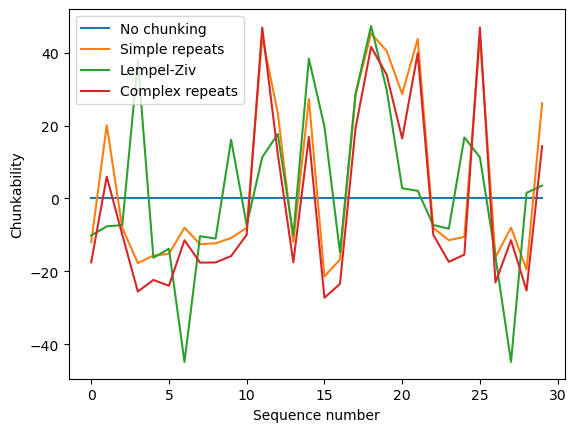

In [90]:
n = 30
np.random.seed(18)
inds = np.random.choice(np.arange(len(chunk1)), n)

plt.plot(np.arange(n), np.zeros(n), label='No chunking')
plt.plot(np.arange(n), np.array(chunk1)[inds], label='Simple repeats')
plt.plot(np.arange(n), np.array(chunk2)[inds], label='Lempel-Ziv')
plt.plot(np.arange(n), np.array(chunk3)[inds], label='Complex repeats')
plt.legend()
plt.xlabel('Sequence number')
plt.ylabel('Chunkability')



In [ ]:
# Combining data across subjects
# This approach is not ideal because the number of games played by each subject is different
# and each subject may have a different distribution of scores

np.random.seed(1234)
data_paths_ = ['./Ajani_logs', './Annesya_logs', './Gershman_logs', './Hokyung_logs',
               './Jack_logs', './Mahdi_logs', './Mel_logs', './Nathan_logs', 
               './Nick_logs', './Quilee_logs', './Sagarika_logs', './Sol_logs/Random', 
               './Trautman_logs', './Vin_logs']

N_subjects = len(data_paths_)
min_games = 5
N_games = np.zeros(N_subjects, dtype=int)
all_scores = []
all_chunk1 = []
all_chunk2 = []
all_chunk3 = []
all_chunk4 = []
all_chunk5 = []

colors = plt.cm.tab20(np.linspace(0, 1, N_subjects))
alpha = 0.4
fig, ax = plt.subplots(1, 3, figsize=(15, 4), sharex=False, sharey=True)

for i, data_path in enumerate(data_paths_):

    chunk_dict = get_chunkabilities_from_logs(data_path)
    scores = chunk_dict['scores']
    chunk1 = chunk_dict['simple_repeats']
    chunk2 = chunk_dict['LZ_complexity']
    chunk3 = chunk_dict['complex_repeats']
    chunk4 = chunk_dict['repeat_alternation']
    chunk5 = chunk_dict['cycle_rep_alt']
    
    N_games[i] = len(scores)

    if N_games[i] < min_games:
        continue
    
    all_scores.extend(scores)
    all_chunk1.extend(chunk1)
    all_chunk2.extend(chunk2)
    all_chunk3.extend(chunk3)

    ax[0].scatter(scores, chunk1, alpha=alpha, color=colors[i])
    ax[1].scatter(scores, chunk3, alpha=alpha, color=colors[i])
    ax[2].scatter(scores, chunk2, alpha=alpha, color=colors[i])


ylabel = 'Chunkability (50 - percentile)'
ax[0].set(ylabel=ylabel, xlabel='Score', title='Simple repeat chunking')
ax[1].set(ylabel=ylabel, xlabel='Score', title='Complex repeat chunking')
ax[2].set(ylabel=ylabel, xlabel='Score', title='Lempel-Ziv complexity')

m1, b1, r1, p1, std_err1 = stats.linregress(all_scores, all_chunk1)
m2, b2, r2, p2, std_err2 = stats.linregress(all_scores, all_chunk2)
m3, b3, r3, p3, std_err3 = stats.linregress(all_scores, all_chunk3)

print('Hyp:   slope,   intercept,   r-value,   p-value,   std_err')
print('Hyp1: ', m1, b1, r1, p1, std_err1)
print('Hyp3: ', m3, b3, r3, p3, std_err3)

ax[0].plot(np.array(all_scores), m1*np.array(all_scores) + b1, color='k', zorder=0, 
           label=f'p-value: {p1:.2e}, R: {r1:.2f}')
ax[1].plot(np.array(all_scores), m3*np.array(all_scores) + b3, color='k', zorder=0, 
           label=f'p-value: {p3:.2e}, R: {r3:.2f}')
ax[2].plot(np.array(all_scores), m2*np.array(all_scores) + b2, color='k', zorder=0,
              label=f'p-value: {p2:.2e}, R: {r2:.2f}')
ax[0].legend(loc='lower right')
ax[1].legend(loc='lower right')
ax[2].legend(loc='lower right')

print(N_games)